# Umbrella Sampling of the two-well potential

Here, we define an umbrella sampling object, `UmbrellaSampler()` that can perform biased sampling of the two-well potential.

In [62]:
import os, sys
import numpy as np

class UmbrellaSampler(object):
    """A Sampler class that can perform biased sampling of the two-well potential."""
    
    def __init__(self,
                 x0_values = [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5],
                 kspring_values  = ([0.0]+[2.0]*9) ):
        """Initialize the UmbrellaSampler class.
        
        PARAMETERS
        x0_values - a list of x0 positions of the umbrella anchors
        kspring_values  - a list of force constant values, in kcal/mol/[x]^2
        """
        
        self.x0_values = x0_values  # Umbrella anchor positions
        self.kspring_values = kspring_values    # force constant values, in kcal/mol/[x]^2
        
        assert len(self.x0_values) == len(self.kspring_values)
        
        self.K = len(self.x0_values)  # the number of thermodynamic ensembles
        
    
    def U(self, x, x0=0.0, kspring=0.0):
        """Return the value of the **biased** 1D potential energy surface in kcal/mol:

        U(x) = -2 \ln [ e^{-2(x-2)^2-2} + e^{-2(x-5)^2} ] + (k/2.)(x - x0)**2
        """
        result = -2.0*np.log( np.exp(-2.0*(x-2)**2 - 2) + np.exp(-2.0*(x-5)**2) )
        result += kspring/2.*(x - x0)**2
        return result

    
    def dU_kl(self, x, k, l):
        """Return the difference of the potential energy $\Delta U_kl(x)$ for a snapshot
        from ensemble index k, re-evaluated in ensemble index l:
        
        \Delta U_kl(x) = (bias from ens. l) - (bias from ens k.)
        
        """
        result = self.kspring_values[l]/2.*(x - self.x0_values[l])**2
        result -= self.kspring_values[k]/2.*(x - self.x0_values[k])**2
         
        return result


    def sample(self, xinit, nsteps, thermo_index, djump=0.05, xmin=1.5, xmax=5.5,
               kT=0.596, nstride=100, nprint=10000, verbose=False):
        """Perform Monte Carlo sampling of the potential energy surface U
        by 

        INPUT
        xinit        - the starting position
        nsteps       - number of steps of Monte Carlo to perform
        thermo_index - the index of the thermodynamic ensemble to sample
        
        PARAMS
        djump    attempt random moves drawn from [-djump, +djump]
        xmin     reject moves x < xmin
        xmax     reject moves x > xmax
        kT       thermal energy in units of kcal/mol (Default: 0.596)
        nstride  frequency of step to subsample the trajectory

        Note:  the djump=0.005 parameter is from the 2017 Stelzl et al. paper    
        """
        
        assert (thermo_index < self.K)
        
        x = xinit
        energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

        step = 0
        accepted_steps = 0
        traj = np.zeros( int(nsteps/nstride) )
        itraj = 0

        # pre-calculate random numbers
        r = np.random.random( nsteps )
        s = np.random.random( nsteps )

        while step < nsteps:

            xnew = x + djump*(2.0*s[step]-1.0)
            new_energy = self.U(xnew, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            # calculate Metropolis acceptance 
            accept = (r[step] < min(1, np.exp( -1.0*(new_energy-energy)/kT ) ))

            # reject moves that bring x outside the range
            accept = accept*(xnew>xmin)*(xnew<xmax)

            if accept:
                accepted_steps += 1
                x = xnew
                energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            if step%nstride == 0:
                traj[itraj] = x
                itraj += 1

            if verbose:
                if step%nprint == 0:
                    print('step', step, 'of', nsteps, ': x =', x, 'energy =', energy)

            step += 1
            acc_ratio = float(accepted_steps)/float(step)

        return traj

Here's a plot of what all the biased potentials in each ensemble looks like:

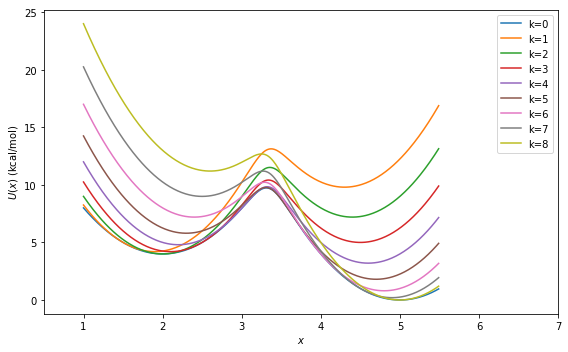

In [80]:
from matplotlib import pyplot as plt
%matplotlib inline

s = UmbrellaSampler()
K = 9

plt.figure(figsize=(8,5))
x = np.arange(1.0, 5.5, 0.01)
for thermo_index in range(K):
    plt.plot(x, s.U(x, s.x0_values[thermo_index], s.kspring_values[thermo_index]), label='k=%d'%thermo_index)
plt.xlabel('$x$')
plt.ylabel('$U(x)$ (kcal/mol)')
plt.legend(loc='upper right')
plt.xlim(0.5, 7.0)
plt.tight_layout()

In [81]:
s = UmbrellaSampler(
        x0_values = ([0.0] + [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]),
        kspring_values  = ([0.0] + [2.0]*9) )
#K = 10  # number of thermodynamic ensembles

ntrials = 5
xinit_per_trial = [1.5, 2.5, 3.5, 4.5, 5.5]
nsteps = 100000
nstride = 100
nsamples = int(nsteps/nstride)
print('nsamples', nsamples)

trajdata = np.zeros( (s.K, ntrials, nsamples))
print('trajdata.shape', trajdata.shape)
print('The `trajdata` array uses', trajdata.nbytes, 'bytes')

for thermo_index in range(s.K):
    print('traj', thermo_index, 'of', s.K, '| trial (of %d): '%ntrials, end ='')
    for trial in range(ntrials):
        trajdata[thermo_index,trial,:] = s.sample(xinit_per_trial[trial],
                                                  nsteps, thermo_index, nstride=nstride,
                                                  xmin=-100.0, xmax=100.0)   # make
        print(trial, end = ' ')
    print('')

nsamples 1000
trajdata.shape (10, 5, 1000)
The `trajdata` array uses 400000 bytes
traj 0 of 10 | trial (of 5): 0 1 2 3 4 
traj 1 of 10 | trial (of 5): 0 1 2 3 4 
traj 2 of 10 | trial (of 5): 0 1 2 3 4 
traj 3 of 10 | trial (of 5): 0 1 2 3 4 
traj 4 of 10 | trial (of 5): 0 1 2 3 4 
traj 5 of 10 | trial (of 5): 0 1 2 3 4 
traj 6 of 10 | trial (of 5): 0 1 2 3 4 
traj 7 of 10 | trial (of 5): 0 1 2 3 4 
traj 8 of 10 | trial (of 5): 0 1 2 3 4 
traj 9 of 10 | trial (of 5): 0 1 2 3 4 


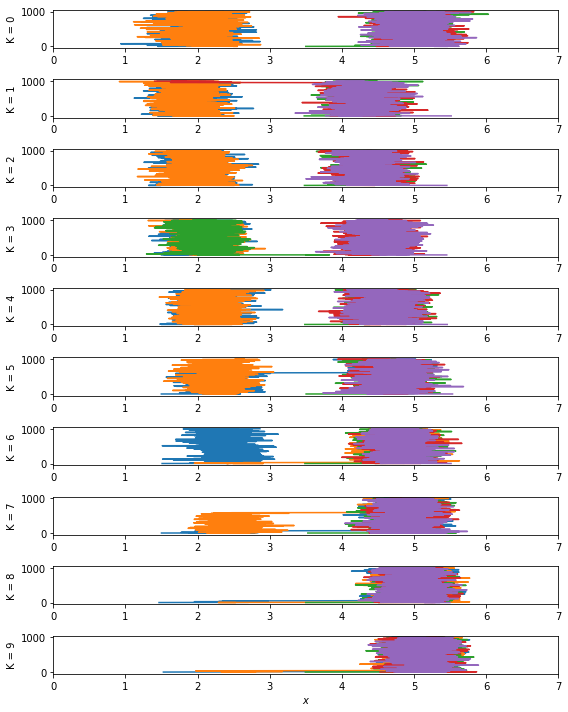

In [82]:
# Plot the results    
plt.figure(figsize=(8,10))
for thermo_index in range(s.K):
    plt.subplot(s.K,1,thermo_index+1)
    for trial in range(ntrials):
        plt.plot(trajdata[thermo_index,trial,:], range(nsamples))
    if thermo_index == (s.K-1):
        plt.xlabel('$x$')
    plt.ylabel('K = %d'%thermo_index)
    plt.xlim(0,7.0)
plt.tight_layout()

## MBAR estimation of the free energy between wells

In [84]:

from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

VERBOSE = False

# N_k is the number of trajectory snapshots sampled in each enesmble 
N_k = nsamples*np.ones([s.K], dtype = int)   # make an empty array for now
if VERBOSE:
    print('N_k', N_k)
N_max = np.max(N_k)
if VERBOSE:
    print('N_max', N_max)


# For each bootstrap, we'll choose some trials at random fo the MBAR calculation
nbootstraps = 50
for boot in range(nbootstraps):
    
    # To instantiate the MBAR object, we create and fill the array u_kln
    K = s.K
    L = K
    u_kln = np.zeros([K,L,N_max], np.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella 

    # To calculate (unbiased) free energies, we need to store reduced
    # energies calculated for the unbiased ensemble (k=0)
    N_tot = N_k.sum()
    u_n = np.zeros(N_tot)
    u_n_fill_indices = [0] 
    for k in range(K):
        u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])

    if VERBOSE:
        print('len(u_n_fill_indices)', len(u_n_fill_indices))
        print('u_n_fill_indices', u_n_fill_indices)
        print('len(u_n)', len(u_n))

    unbiased_thermo_index = 0
    
    trial_indices_for_this_bootstrap = np.random.randint(0, high=ntrials, size=s.K)
    print('trial_indices_for_this_bootstrap', trial_indices_for_this_bootstrap)
    
    for k in range(s.K):    
        trial = trial_indices_for_this_bootstrap[k]
        u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
            s.U(trajdata[k,trial,:], s.x0_values[unbiased_thermo_index], s.kspring_values[unbiased_thermo_index])
        for l in range(L):
            u_kln[k,l,0:N_k[k]] = s.dU_kl(trajdata[k,trial,:], k, l)
    if VERBOSE:
        print('u_kln', u_kln)
        print('u_n', u_n)


    ## Instantiate the MBAR object
    print("Running MBAR...")
    mbar = MBAR(u_kln, N_k, verbose = True)

    if (1):
        print('Computing PMF(x) for trial', trial)

        # bin the data up into distance bins
        nbins = 2
        x_separatrix = 3.3123765271592047
        dmin, dmax = x_separatrix, (x_separatrix + 10.0)  # in nm
        dwidth = (dmax-dmin)/nbins
        distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
        bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0
        print('bin_centers', bin_centers)

        bin_n = np.zeros(N_tot)

        for k in range(s.K):
            trial = trial_indices_for_this_bootstrap[k]
            bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                np.digitize(trajdata[k,trial,:], distance_bins, right=False)
        # print('bin_n', bin_n)

        # Compute PMF in unbiased potential (in units of kT).
        results = mbar.computePMF(u_n, bin_n, nbins)
        f_i = results[0]
        df_i = results[1]

        # Write out PMF
        print("PMF (in units of kT)")
        print("%8s %8s %8s" % ('bin', 'f', 'df'))
        for i in range(nbins):
            print("%8.1f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i]))

    # cleanup
    del mbar

trial_indices_for_this_bootstrap [3 3 4 0 0 4 1 1 4 3]
Running MBAR...
K (total states) = 10, total samples = 10000
N_k = 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
There are 10 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final dimensionless free energies
f_k = 
[0.         4.84919483 4.340078   3.86198966 2.85920987 1.67700034
 0.77187529 0.24777879 0.12381782 0.40855708]
MBAR initialization complete.
Computing PMF(x) for trial 3
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8    8.553    0.054
    10.8    0.000    0.000
trial_indices_for_this_bootstrap [2 2 1 4 4 3 2 2 1 3]
Running MBAR...
K (total states) = 10, total samples = 10000
N_k = 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
There are 10 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0.

Final dimensionless free energies
f_k = 
[0.         0.99494111 0.68347614 0.78435792 1.22497246 1.59903797
 1.36026148 1.00481409 0.95189958 1.28329725]
MBAR initialization complete.
Computing PMF(x) for trial 3
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8    3.660    0.044
    10.8    0.000    0.000
trial_indices_for_this_bootstrap [3 4 1 3 3 2 4 4 2 0]
Running MBAR...
K (total states) = 10, total samples = 10000
N_k = 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
There are 10 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final dimensionless free energies
f_k = 
[0.         8.5682495  7.08590101 5.07757618 3.27199498 1.85518022
 0.84895743 0.25810804 0.08633229 0.3373484 ]
MBAR initialization complete.
Computing PMF(x) for trial 0
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8  

Final dimensionless free energies
f_k = 
[0.         6.26974009 5.6357702  4.60106457 3.10774131 1.78056873
 0.81980658 0.25674656 0.10113637 0.36019465]
MBAR initialization complete.
Computing PMF(x) for trial 0
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8    9.871    0.054
    10.8    0.000    0.000
trial_indices_for_this_bootstrap [3 0 3 3 0 1 0 1 1 4]
Running MBAR...
K (total states) = 10, total samples = 10000
N_k = 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
There are 10 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final dimensionless free energies
f_k = 
[0.         1.59097218 1.20899636 1.21618325 1.49816787 1.55742474
 1.08692646 0.65350386 0.5490966  0.82927014]
MBAR initialization complete.
Computing PMF(x) for trial 4
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8  

Final dimensionless free energies
f_k = 
[0.         6.97180376 5.97232682 4.55126433 2.97563585 1.67220276
 0.7508932  0.22903651 0.11162347 0.40353291]
MBAR initialization complete.
Computing PMF(x) for trial 1
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8   11.216    0.057
    10.8    0.000    0.000
trial_indices_for_this_bootstrap [4 4 1 3 1 2 1 4 0 2]
Running MBAR...
K (total states) = 10, total samples = 10000
N_k = 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
There are 10 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final dimensionless free energies
f_k = 
[0.         6.16863857 5.60568001 4.64286679 3.15308687 1.80978543
 0.83595591 0.26345499 0.10000004 0.35095242]
MBAR initialization complete.
Computing PMF(x) for trial 2
bin_centers [ 5.81237653 10.81237653]
PMF (in units of kT)
     bin        f       df
     5.8  